# Example: PyRayHF Cartesian Gradient Raytracing

### Background: Ray Equations in a Plasma

Unlike Snell’s law approaches (which assume stratification and mirror the up-leg to construct the down-leg), the **gradient-based method** solves the full **ray equations** in Cartesian geometry:

- **Ray position**: $r = (x, z)$ [km]
- **Unit tangent vector**: $v = (vx, vz)$ with $||v||$ = 1
- **Arc length**: $s$ [km]
- **Refractive index field**: $n(x, z) = μ$ (phase index)

The equations of motion are:
$$
dr/ds = v
$$
$$
dv/ds = (1/n) [ ∇n − (∇n · v) v ]
$$


This form ensures that the velocity vector v remains normalized, and the ray bends naturally according to the spatial gradients of μ.

---

### Specifics in PyRayHF

- Geometry (bending) uses the **phase index $μ$**
- Group delay integrates the **group index $μ$'** (mup) if provided via `mup_func`
- The refractive index and its gradients are supplied by `build_refractive_index_interpolator`
- Cartesian geometry assumes a **flat Earth** (no curvature effects)
- Termination conditions stop the ray when it:
  - Reaches the ground
  - Leaves the vertical or horizontal domain
  - Exceeds maximum arc length

This method is more general than Snell’s law since it handles arbitrary 2-D gradients, not only stratified profiles.


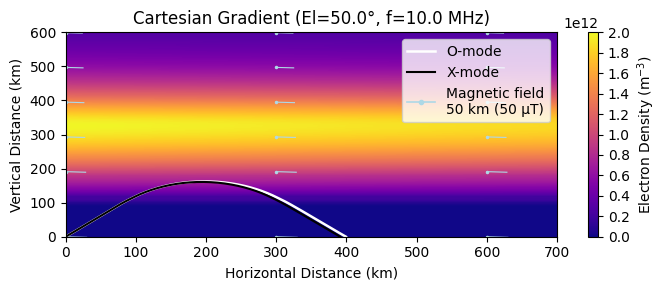

--------------------------------------------------
Gradient-based raytracing in a medium with gradient O-mode:
--------------------------------------------------
Group Path (km):  533.2935441070074
Group delay (sec):  0.002084552645634903
Ground_ Range (km):  399.2074423692366
x midpoint (km):  211.23973664642114
z midpoint (km):  161.6690977040689
--------------------------------------------------
Gradient-based raytracing in a medium with gradient X-mode:
--------------------------------------------------
Group Path (km):  524.3262524367606
Group delay (sec):  0.0020552258861337774
Ground_ Range (km):  391.04839311395443
x midpoint (km):  211.64578330276362
z midpoint (km):  159.47147665420414
--------------------------------------------------
Elapsed time (sec):  0.2918268579815049
--------------------------------------------------


In [4]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_refractive_index_interpolator_cartesian
from PyRayHF.library import trace_ray_cartesian_gradient
from PyRayHF.library import build_mup_function
import time

# Directory on your local machine where to save the figures
local_dir = '../figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Add some gradient to it
Ne_gradient = Ne_grid * (1.0 - 0.1 * (Xg / Xg.max()))

# Start the timer to time the code
start_time = time.perf_counter()

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

# O-mode:
mode = "O"

mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from mup grid (validated)
n_and_grad = build_refractive_index_interpolator_cartesian(z_grid, x_grid, mu)

# Build μ' (group) for delay only
mup_func_cartesian = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="cartesian")

# Raytrace
result_O = trace_ray_cartesian_gradient(n_and_grad=n_and_grad,
                                        x0_km=0.0,
                                        z0_km=0.0,
                                        elevation_deg=elevation_deg,
                                        s_max_km=4000.0,
                                        max_step_km=5.0,
                                        z_max_km=600.0,
                                        x_min_km=0.0,
                                        x_max_km=1000.0,
                                        mup_func=mup_func_cartesian)
# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# X-mode:
mode = "X"

mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from mup grid (validated)
n_and_grad = build_refractive_index_interpolator_cartesian(z_grid, x_grid, mu)

# Build μ' (group) for delay only
mup_func_cartesian = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="cartesian")

# Raytrace
result_X = trace_ray_cartesian_gradient(n_and_grad=n_and_grad,
                                        x0_km=0.0,
                                        z0_km=0.0,
                                        elevation_deg=elevation_deg,
                                        s_max_km=4000.0,
                                        max_step_km=5.0,
                                        z_max_km=600.0,
                                        x_min_km=0.0,
                                        x_max_km=1000.0,
                                        mup_func=mup_func_cartesian)

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_xlim(0, 700)
ax.set_ylim(0, 600)
ax.set_facecolor("lightgray")
ax.set_ylabel('Vertical Distance (km)')
ax.set_xlabel('Horizontal Distance (km)')

# --- Electron density background
vmin, vmax = 0, 2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                   cmap='plasma', vmin=vmin, vmax=vmax)

# --- Magnetic field visualization (simple line segments with dots)
# Babs is in Tesla (≈3–6e-5), convert to relative visual length
B_scale = 1e6  # empirical scaling factor to make lines a few tens of km long
Bx = Babs * np.sin(np.deg2rad(bpsi)) * B_scale
Bz = -Babs * np.cos(np.deg2rad(bpsi)) * B_scale

# Subsample altitudes for clarity
step_z = max(1, len(alt_km)//5)
z_sample = alt_km[::step_z]
Bx_sample = Bx[::step_z]
Bz_sample = Bz[::step_z]

# Repeat horizontally every 300 km
x_spacing = 300  # km
x_repeat = np.arange(0, ax.get_xlim()[1], x_spacing)

for x_offset in x_repeat:
    for zs, bx, bz in zip(z_sample, Bx_sample, Bz_sample):
        xs, xe = x_offset, x_offset + bx
        ze = zs + bz
        ax.plot([xs, xe], [zs, ze], color='lightblue', lw=0.8)
        ax.plot(xs, zs, 'o', color='lightblue', ms=1.5)

# --- Plot the actual ray paths
line_O, = ax.plot(result_O['x'], result_O['z'], c='white', lw=1.8, label='O-mode')
line_X, = ax.plot(result_X['x'], result_X['z'], c='black', lw=1.5, label='X-mode')

# --- Add custom magnetic field legend handle
B_ref = 50e-6  # 50 µT reference
line_length_km = B_ref * B_scale  # visible line length
legend_line = Line2D([0, 1], [0, 0], color='lightblue', lw=1.2,
                     marker='o', markersize=3,
                     label=f'Magnetic field\n{line_length_km:.0f} km (50 µT)')

# --- Labels, colorbar, legend
ax.set_title(f"Cartesian Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6:.1f} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax, ticks=color_ticks)

ax.legend(handles=[line_O, line_X, legend_line], loc='upper right')

plt.tight_layout()
plt.savefig(local_dir + 'Cartesian_Gradient.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
 
# Print diagnostics
print('--------------------------------------------------')
print('Gradient-based raytracing in a medium with gradient O-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_O['group_path_km'])
print('Group delay (sec): ', result_O['group_delay_sec'])
print('Ground_ Range (km): ', result_O['ground_range_km'])
print('x midpoint (km): ', result_O['x_midpoint'])
print('z midpoint (km): ', result_O['z_midpoint'])

print('--------------------------------------------------')
print('Gradient-based raytracing in a medium with gradient X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_X['group_path_km'])
print('Group delay (sec): ', result_X['group_delay_sec'])
print('Ground_ Range (km): ', result_X['ground_range_km'])
print('x midpoint (km): ', result_X['x_midpoint'])
print('z midpoint (km): ', result_X['z_midpoint'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')